<a href="https://colab.research.google.com/github/PsorTheDoctor/deep-neural-nets/blob/main/week9_recurrent_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

In [1]:
import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
# from google_drive_downloader import GoogleDriveDownloader as gdd

# Email spam classifier

In [ ]:
# Download data

# gdd.download_file_from_google_drive('13DLnvpRhDO-D5JHCuPq85k_v-yMiMNCQ', '~/lingsmap_public-bare.zip', unzip=True)
!gdown 'https://drive.google.com/uc?id=13DLnvpRhDO-D5JHCuPq85k_v-yMiMNCQ'
!unzip '/content/lingsmap_public-bare.zip'
assert Path('/content/lingsmap_public-bare').exists()

  0%|          | 0/2893 [00:00<?, ?it/s]

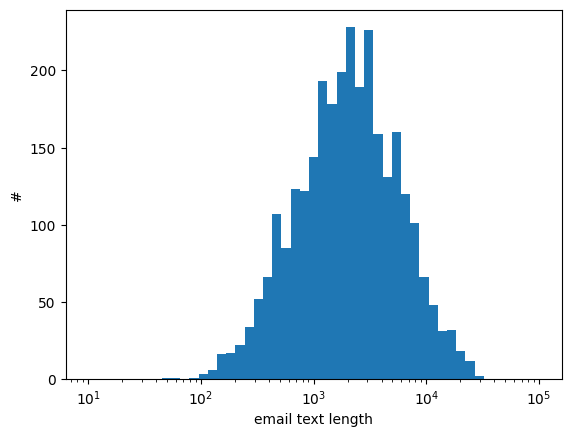

2893 emails
percentage spam: 0.17
ascii codes between 10 and 126


In [3]:
# Load data
filepaths = glob.glob('/content/lingsmap_public-bare/*/*.txt')
emails = []
emails_ascii = []
targets = []

for i, filepath in enumerate(tqdm(filepaths)):
    with open(filepath) as file:
        email = file.read()
    emails.append(email)
    emails_ascii.append([ord(c) for c in email])  # convert character to ascii code
    targets.append('spmsg' in filepath)

plt.hist([len(e) for e in emails], np.logspace(1, 5))
plt.xlabel('email text length')
plt.ylabel('#')
plt.xscale('log')
plt.show()

print(f'{len(emails)} emails')
print(f'percentage spam: {np.mean(targets):.2f}')
emails_ascii_flat = np.concatenate(emails_ascii)
print(f'ascii codes between {emails_ascii_flat.min()} and {emails_ascii_flat.max()}')

So even if we just guess 'not spam' all the time, we can get 83 % correct. Lets consider this as the **baseline**.

In [ ]:
# lets read few examples our loaded data
for i in range(4):
    print(f'----  Spam: {targets[i]}  ----')
    print(emails[i], '\n')
    print(emails_ascii[i], '\n')

In [5]:
class SpamDataset:
    def __init__(self, emails_ascii, targets, text_length, sample=False):
        self.emails_ascii = emails_ascii
        self.targets = targets
        self.text_length = text_length
        self.sample = sample

    def __len__(self):
        return len(self.emails_ascii)

    def __getitem__(self, i):
        text = self.emails_ascii[i]
        if self.sample:
            start_idx = np.random.randint(max(1, len(text) - self.text_length))
        else:
            start_idx = 0
        text = text[start_idx:start_idx+self.text_length]
        end_idx = len(text) - 1
        text = text + [0] * (self.text_length - len(text))
        assert len(text) == self.text_length
        text = np.array(text, dtype=int)
        return text, end_idx, self.targets[i]

In [6]:
n_valid = 250
data_train = SpamDataset(emails_ascii[:-n_valid], targets[:-n_valid], 100, sample=True)
data_valid = SpamDataset(emails_ascii[-n_valid:], targets[-n_valid:], 500)

print(f'{np.sum(targets[-n_valid:])} spam mails in the validation set')

loader_kwargs = dict(batch_size=32, num_workers=4)
loader_train = torch.utils.data.DataLoader(data_train, shuffle=True, **loader_kwargs)
loader_valid = torch.utils.data.DataLoader(data_valid, **loader_kwargs)

44 spam mails in the validation set


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Task**

* Create a class to load the dataset (see [Data Tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html))
    * To be able to batch emails, they have to have the same length. You can ensure this in different ways e.g. zero-padding
    * Make a training and validation set based on *emails_ascii* and *targets*  
* Create and train a recurrent model to classify whether the emails are spam or not
    * Have a look at the [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) module and the [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module

In [37]:
class RNN(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=512, n_layers=1,
                 mode='lstm', bidirectional=False):
        super().__init__()
        self.embed = nn.Embedding(input_dim, hidden_dim)
        if mode == 'rnn':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, n_layers,
                batch_first=True, bidirectional=bidirectional
            )
        elif mode == 'lstm':
            self.rnn = nn.LSTM(hidden_dim, hidden_dim // 2, n_layers,
                batch_first=True, bidirectional=bidirectional
            )
        elif mode == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, n_layers,
                batch_first=True, bidirectional=bidirectional
            )
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x, end_idx):
        x = self.embed(x)
        y = self.rnn(x)[0][torch.arange(len(x)), end_idx]
        return self.linear(y).view(-1)

In [38]:
device = torch.device('cuda')
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []
lrs = []


def fit(epochs, mode, bidirectional):
    model = RNN(mode=mode, bidirectional=bidirectional).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    sched = torch.optim.lr_scheduler.MultiStepLR(opt, (30,))

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        # Train
        model.train()
        losses = []
        correct = total = 0
        for x, end_idx, y in loader_train:
            x, end_idx, y = x.to(device), end_idx.to(device), y.to(device)
            logits = model(x, end_idx)

            loss = F.binary_cross_entropy_with_logits(logits, y.float())
            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())
            total += len(x)
            correct += ((torch.sigmoid(logits) > 0.5) == y).sum().item()
        train_loss = np.mean(losses)
        train_acc = correct / total

        model.eval()
        losses = []
        correct = total = 0
        for x, end_idx, y in loader_valid:
            x, end_idx, y = x.to(device), end_idx.to(device), y.to(device)
            with torch.no_grad():
                logits = model(x, end_idx)

            loss = F.binary_cross_entropy_with_logits(logits, y.float())
            losses.append(loss.item())
            total += len(x)
            correct += ((torch.sigmoid(logits) > 0.5) == y).sum().item()
        valid_loss = np.mean(losses)
        valid_acc = correct / total

        sched.step()
        lrs.append(next(iter(opt.param_groups))['lr'])  # history

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)

        pbar.set_description(f'loss: {train_loss:.3f}/{valid_loss:.3f}, acc: {train_acc:.2f}/{valid_acc:.2f}')

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].plot(train_losses, label='train')
    axs[0].plot(valid_losses, label='valid')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    axs[1].plot(train_accuracies, label='train')
    axs[1].plot(valid_accuracies, label='valid')
    axs[1].set_ylabel('acc')
    axs[1].set_ylim(0.8, 1)
    axs[1].legend()
    axs[2].plot(lrs)
    axs[2].set_ylabel('lr')
    axs[2].set_yscale('log')
    plt.tight_layout()
    plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

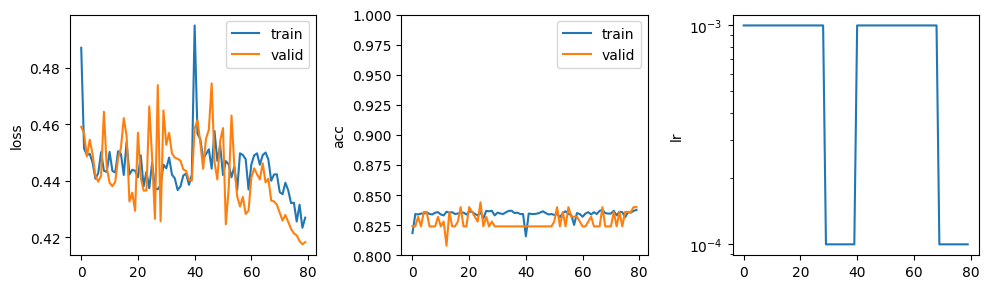

In [33]:
fit(epochs=40, mode='rnn', bidirectional=False)

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


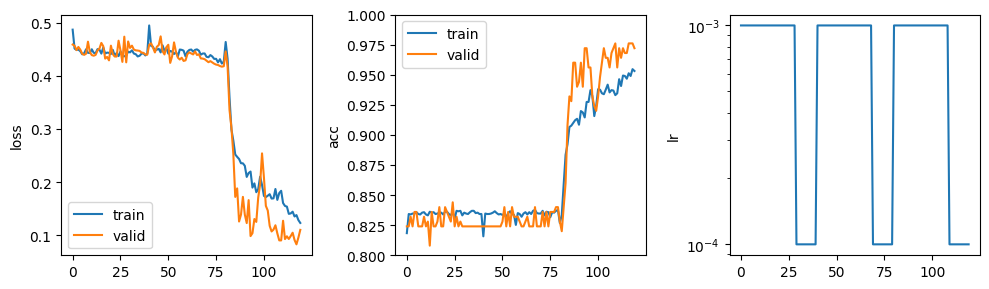

In [34]:
fit(epochs=40, mode='lstm', bidirectional=False)

  0%|          | 0/40 [00:00<?, ?it/s]

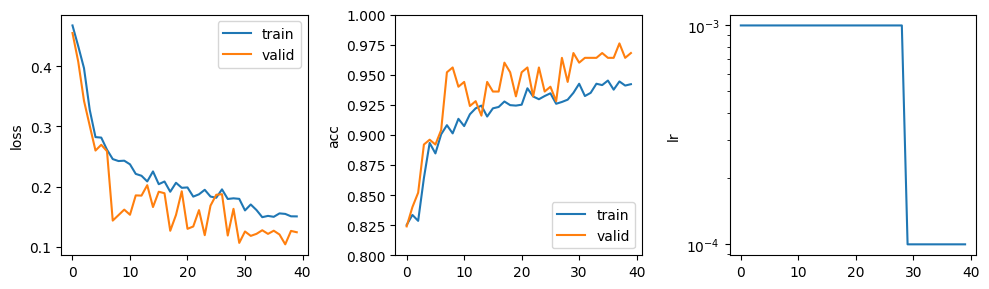

In [39]:
fit(epochs=40, mode='lstm', bidirectional=True)

# Bonus - Number sorting

In [41]:
class LSTM_AutoEncoder(nn.Module):
    def __init__(self, hidden_dim=256, n_layers=1):
        super().__init__()
        self.lin_input = nn.Linear(1, hidden_dim)
        self.encoder = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.lin_output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.lin_input(x)
        y, (c, h) = self.encoder(x)
        # Use the last output of the encoder as the input for the decoder
        x = y[:, -1:].expand(-1, x.shape[1], -1)
        y, _ = self.decoder(x, (c, h))
        return self.lin_output(y)

In [53]:
def train_sorter(nx_range, epochs=20, bs=128, batches_per_epoch=100):
    model = LSTM_AutoEncoder().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        losses = []
        for _ in range(batches_per_epoch):
            nx = torch.randint(nx_range[0], nx_range[1] + 1, (1,))
            x = torch.randn(bs, nx, 1).to(device)
            y = x.sort(dim=1)[0]
            y_hat = model(x)

            loss = F.mse_loss(y_hat, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        train_loss = np.mean(losses)
        pbar.set_description(f'loss: {train_loss:.3f}')

    return model

nx_range during training (5, 5)


  0%|          | 0/20 [00:00<?, ?it/s]

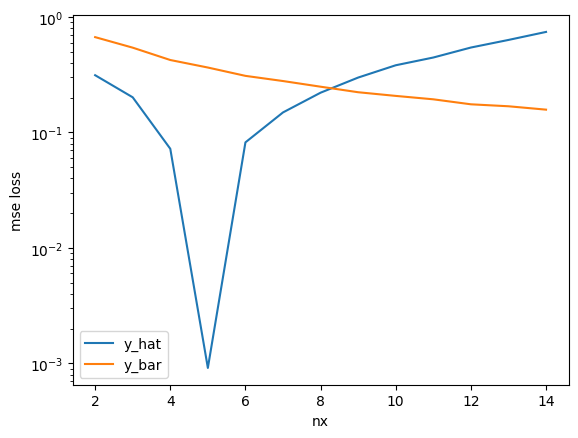

nx_range during training (8, 8)


  0%|          | 0/20 [00:00<?, ?it/s]

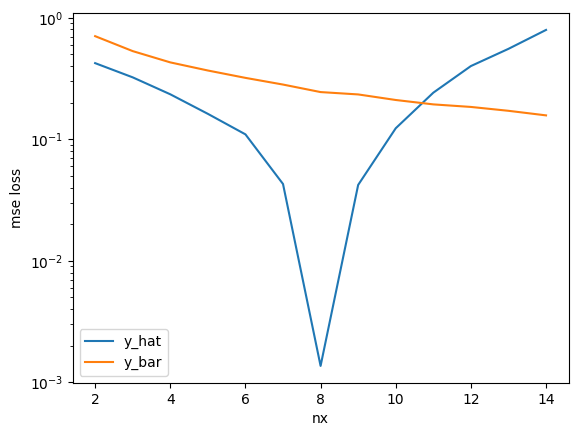

nx_range during training (5, 8)


  0%|          | 0/20 [00:00<?, ?it/s]

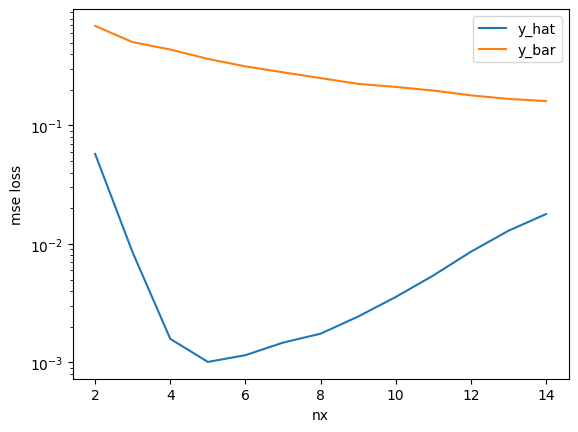

nx_range during training (2, 10)


  0%|          | 0/20 [00:00<?, ?it/s]

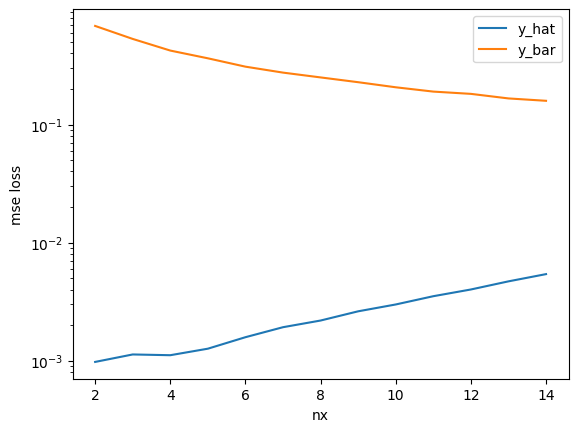

In [57]:
nxs = np.arange(2, 15)

for nx_range in (5, 5), (8, 8), (5, 8), (2, 10):
    print('nx_range during training', nx_range)
    model = train_sorter(nx_range)

    losses = []
    y_bar_losses = []
    for nx in nxs:
        x_ = torch.randn(2000, nx, 1).to(device)
        y_ = x_.sort(dim=1)[0]

        with torch.no_grad():
            y_hat = model(x_)
        losses.append(F.mse_loss(y_hat, y_).cpu().numpy())

        y_bar = y_.mean(0, keepdim=True)
        y_bar_losses.append(F.mse_loss(y_bar.expand_as(y_), y_).cpu().numpy())

    plt.plot(nxs, losses, label='y_hat')
    plt.plot(nxs, y_bar_losses, label='y_bar')
    plt.xlabel('nx')
    plt.ylabel('mse loss')
    plt.yscale('log')
    plt.legend()
    plt.show()